Steane code error detection ancilla readings
====================================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla

3. Force an error and confirm that the ancilla identify this error even with noise

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    mean_of_list,
    calculate_standard_error,
    get_parity_check_matrix,
    get_codewords,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET
ANCILLA_QUBITS = 3
ERROR_REDUCTION = 1

NOISE = True                                              #Test with noise
SHOTS = 10000                                             #Number of shots to run   
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION 
ITERATIONS = 25
SIMULATOR = Aer.get_backend('qasm_simulator')

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


Define runs

In [5]:
runs = {'I':{},
        'X1':{'test_x_qubit': 0},
        'X2':{'test_x_qubit': 1},
        'X3':{'test_x_qubit': 2},
        'X4':{'test_x_qubit': 3},
        'X5':{'test_x_qubit': 4},
        'X6':{'test_x_qubit': 5},
        'X7':{'test_x_qubit': 6},
        'Z1':{'test_z_qubit': 0},
        'Z2':{'test_z_qubit': 1},
        'Z3':{'test_z_qubit': 2},
        'Z4':{'test_z_qubit': 3},
        'Z5':{'test_z_qubit': 4},
        'Z6':{'test_z_qubit': 5},
        'Z7':{'test_z_qubit': 6}
       }

Error detection
---------------------

The error detection circuit is added to the encoding circuit and transpiled.

In [6]:
print(f'Run with {SHOTS} shots and {ITERATIONS} iterations')
#initialise lists for graphs results
values_graph = [[] for i in range(ANCILLA_QUBITS * 2)]
standard_error_graph= [[] for i in range(ANCILLA_QUBITS * 2)]
labels_list = [str(j) + str(i + 1) for j in ['x', 'z'] for i in range(3)]
cases_list = []

for cases, parameters in runs.items():
    print()
    print(f'Error introduced {cases}')
    cases_list.append(cases)
    test_x = True
    if 'test_x_qubit' in parameters:
        x_bit = parameters.get('test_x_qubit')
    else:
        test_x = False
    test_z = True
    if 'test_z_qubit' in parameters:
        z_bit = parameters.get('test_z_qubit')
    else:
        test_z = False
    results_list = [[] for i in range(ANCILLA_QUBITS * 2)]
    for iteration in range(ITERATIONS):    
        qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords)
        qubit.set_up_logical_zero()
        qubit.barrier()
        if test_x:
            qubit.force_X_error(x_bit)   #force X error for testing
        if test_z:
            qubit.force_Z_error(z_bit)   #force Z error for testing
        qubit.barrier()
        qubit.set_up_ancilla()
        qubit.barrier()
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                                    TWO_GATE_DEPOLARISING, SINGLE_GATE_SET, TWO_GATE_SET)
        qubit.logical_measure_data()
        qubit.logical_measure_ancilla()
        qubit.barrier()
        qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qt)
        # calculate location of ancilla 
        for i in ['x', 'z']:
            if i == 'x':
                location = 0        
            elif i == 'z':
                location = 1
            else:
                raise Exception ('Unexpected ancilla value') 
            # find ancilla values for relevant location
            ancilla_values = find_ancilla_values(counts, ANCILLA_QUBITS, location) 
            #i is first part of ancilla label
            individual_ancilla_values = find_individual_ancilla_values(ancilla_values, 0, ANCILLA_QUBITS, i)
            index = 0
            for labels in labels_list:
                if labels in individual_ancilla_values.keys():
                    result = individual_ancilla_values.get(labels) / SHOTS
                    results_list[index].append(result)
                index = index + 1 
    index = 0
    for labels in labels_list:
        #find mean and standard deviation for all iterations
        mean = mean_of_list(results_list[index])
        standard_devation, standard_error = calculate_standard_error(results_list[index])  
        values_graph[index].append(mean)
        standard_error_graph[index].append(standard_error)
        print(f'For ancilla {labels} the mean is {mean:.4f} and the standard_error is {standard_error:.4f}')
        index = index + 1

Run with 10000 shots and 25 iterations

Error introduced I
For ancilla x1 the mean is 0.2145 and the standard_error is 0.0011
For ancilla x2 the mean is 0.2409 and the standard_error is 0.0010
For ancilla x3 the mean is 0.2712 and the standard_error is 0.0011
For ancilla z1 the mean is 0.1079 and the standard_error is 0.0007
For ancilla z2 the mean is 0.1334 and the standard_error is 0.0008
For ancilla z3 the mean is 0.1639 and the standard_error is 0.0008

Error introduced X1
For ancilla x1 the mean is 0.2149 and the standard_error is 0.0008
For ancilla x2 the mean is 0.2401 and the standard_error is 0.0009
For ancilla x3 the mean is 0.7283 and the standard_error is 0.0010
For ancilla z1 the mean is 0.1068 and the standard_error is 0.0005
For ancilla z2 the mean is 0.1329 and the standard_error is 0.0005
For ancilla z3 the mean is 0.1652 and the standard_error is 0.0006

Error introduced X2
For ancilla x1 the mean is 0.2142 and the standard_error is 0.0010
For ancilla x2 the mean is 0

Plot graph

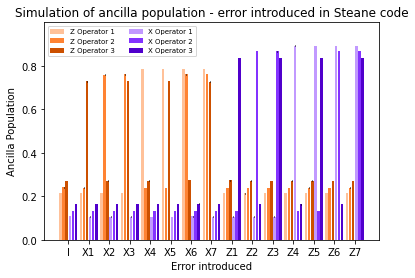

In [7]:
#graph constants
graph_labels_list = [str(j) + ' Operator ' +  str(i + 1) for j in ['Z', 'X'] for i in range(3)]
YMIN = 0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.15
GAP = .8
BAR_WIDTH = 1
x = np.arange(len(cases_list))  # the label locations

fig, ax = plt.subplots()
plt.bar(x - WIDTH * 5 / 2, values_graph[0], color = '#ffc199', width = WIDTH * GAP, label = graph_labels_list[0])
plt.bar(x - WIDTH * 3 / 2,values_graph[1], color = '#ff8333', width = WIDTH * GAP, label = graph_labels_list[1])
plt.bar(x - WIDTH / 2, values_graph[2], color = '#cc5000', width = WIDTH * GAP, label = graph_labels_list[2])
plt.bar(x + WIDTH / 2, values_graph[3], color = '#c199ff', width = WIDTH * GAP, label = graph_labels_list[3])
plt.bar(x + WIDTH * 3 /2, values_graph[4], color = '#8333ff', width = WIDTH * GAP, label = graph_labels_list[4])
plt.bar(x + WIDTH * 5 /2, values_graph[5], color = '#5000cc', width = WIDTH * GAP, label = graph_labels_list[5])

plt.errorbar(x - WIDTH  * 5 / 2, values_graph[0], yerr = standard_error_graph[0], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH)
plt.errorbar(x - WIDTH  * 3 / 2, values_graph[1], yerr = standard_error_graph[1], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH )
plt.errorbar(x - WIDTH  / 2, values_graph[2], yerr = standard_error_graph[2], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH )
plt.errorbar(x + WIDTH  / 2, values_graph[3], yerr = standard_error_graph[3], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH )
plt.errorbar(x + WIDTH  * 3 / 2, values_graph[4], yerr = standard_error_graph[4], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH )
plt.errorbar(x + WIDTH  * 5 / 2, values_graph[5], yerr = standard_error_graph[5], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH )

ax.set_xlabel('Error introduced')
ax.set_ylabel('Ancilla Population')
ax.set_title('Simulation of ancilla population - error introduced in Steane code')
ax.set_xticks(x)
ax.set_xticklabels(cases_list)
ax.legend(prop={"size":7}, loc="upper left", ncol=2)
plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))

fname = "Steane_code_ancilla_graph.png"
plt.savefig(fname)

Draw circuit

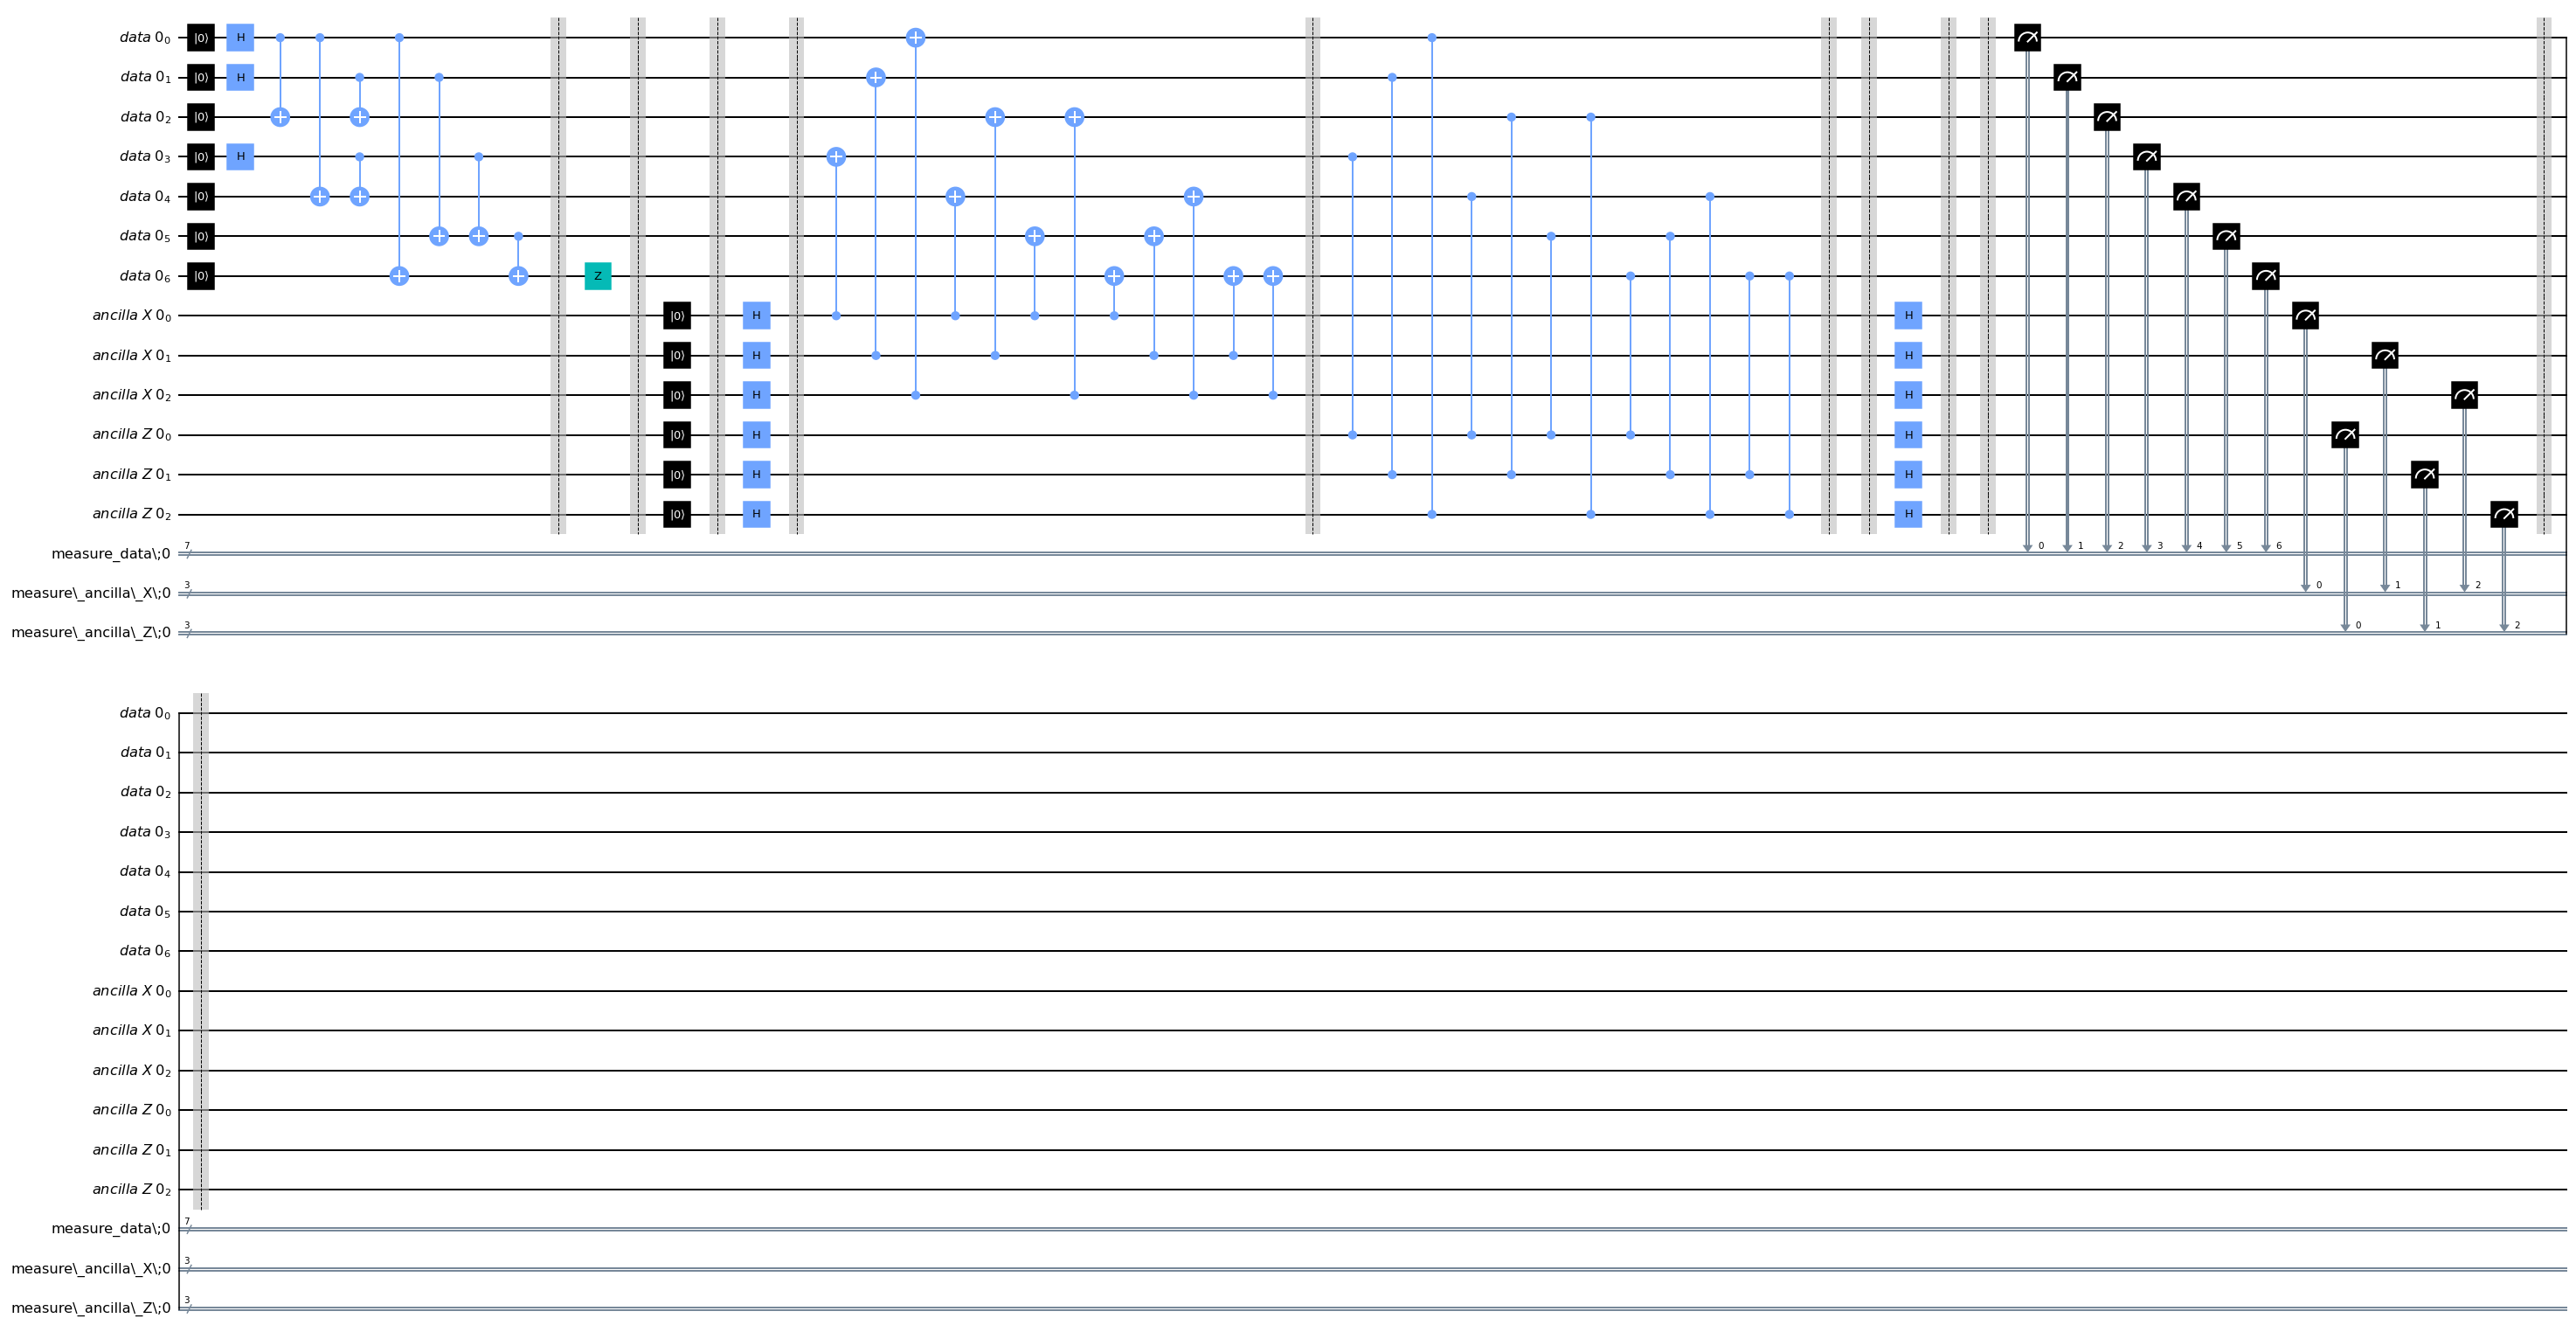

In [8]:
qubit.draw(output = 'mpl', filename = 'Steane_code_error_detection_circuit.jpg', fold = 60)

Draw transpiled circuit

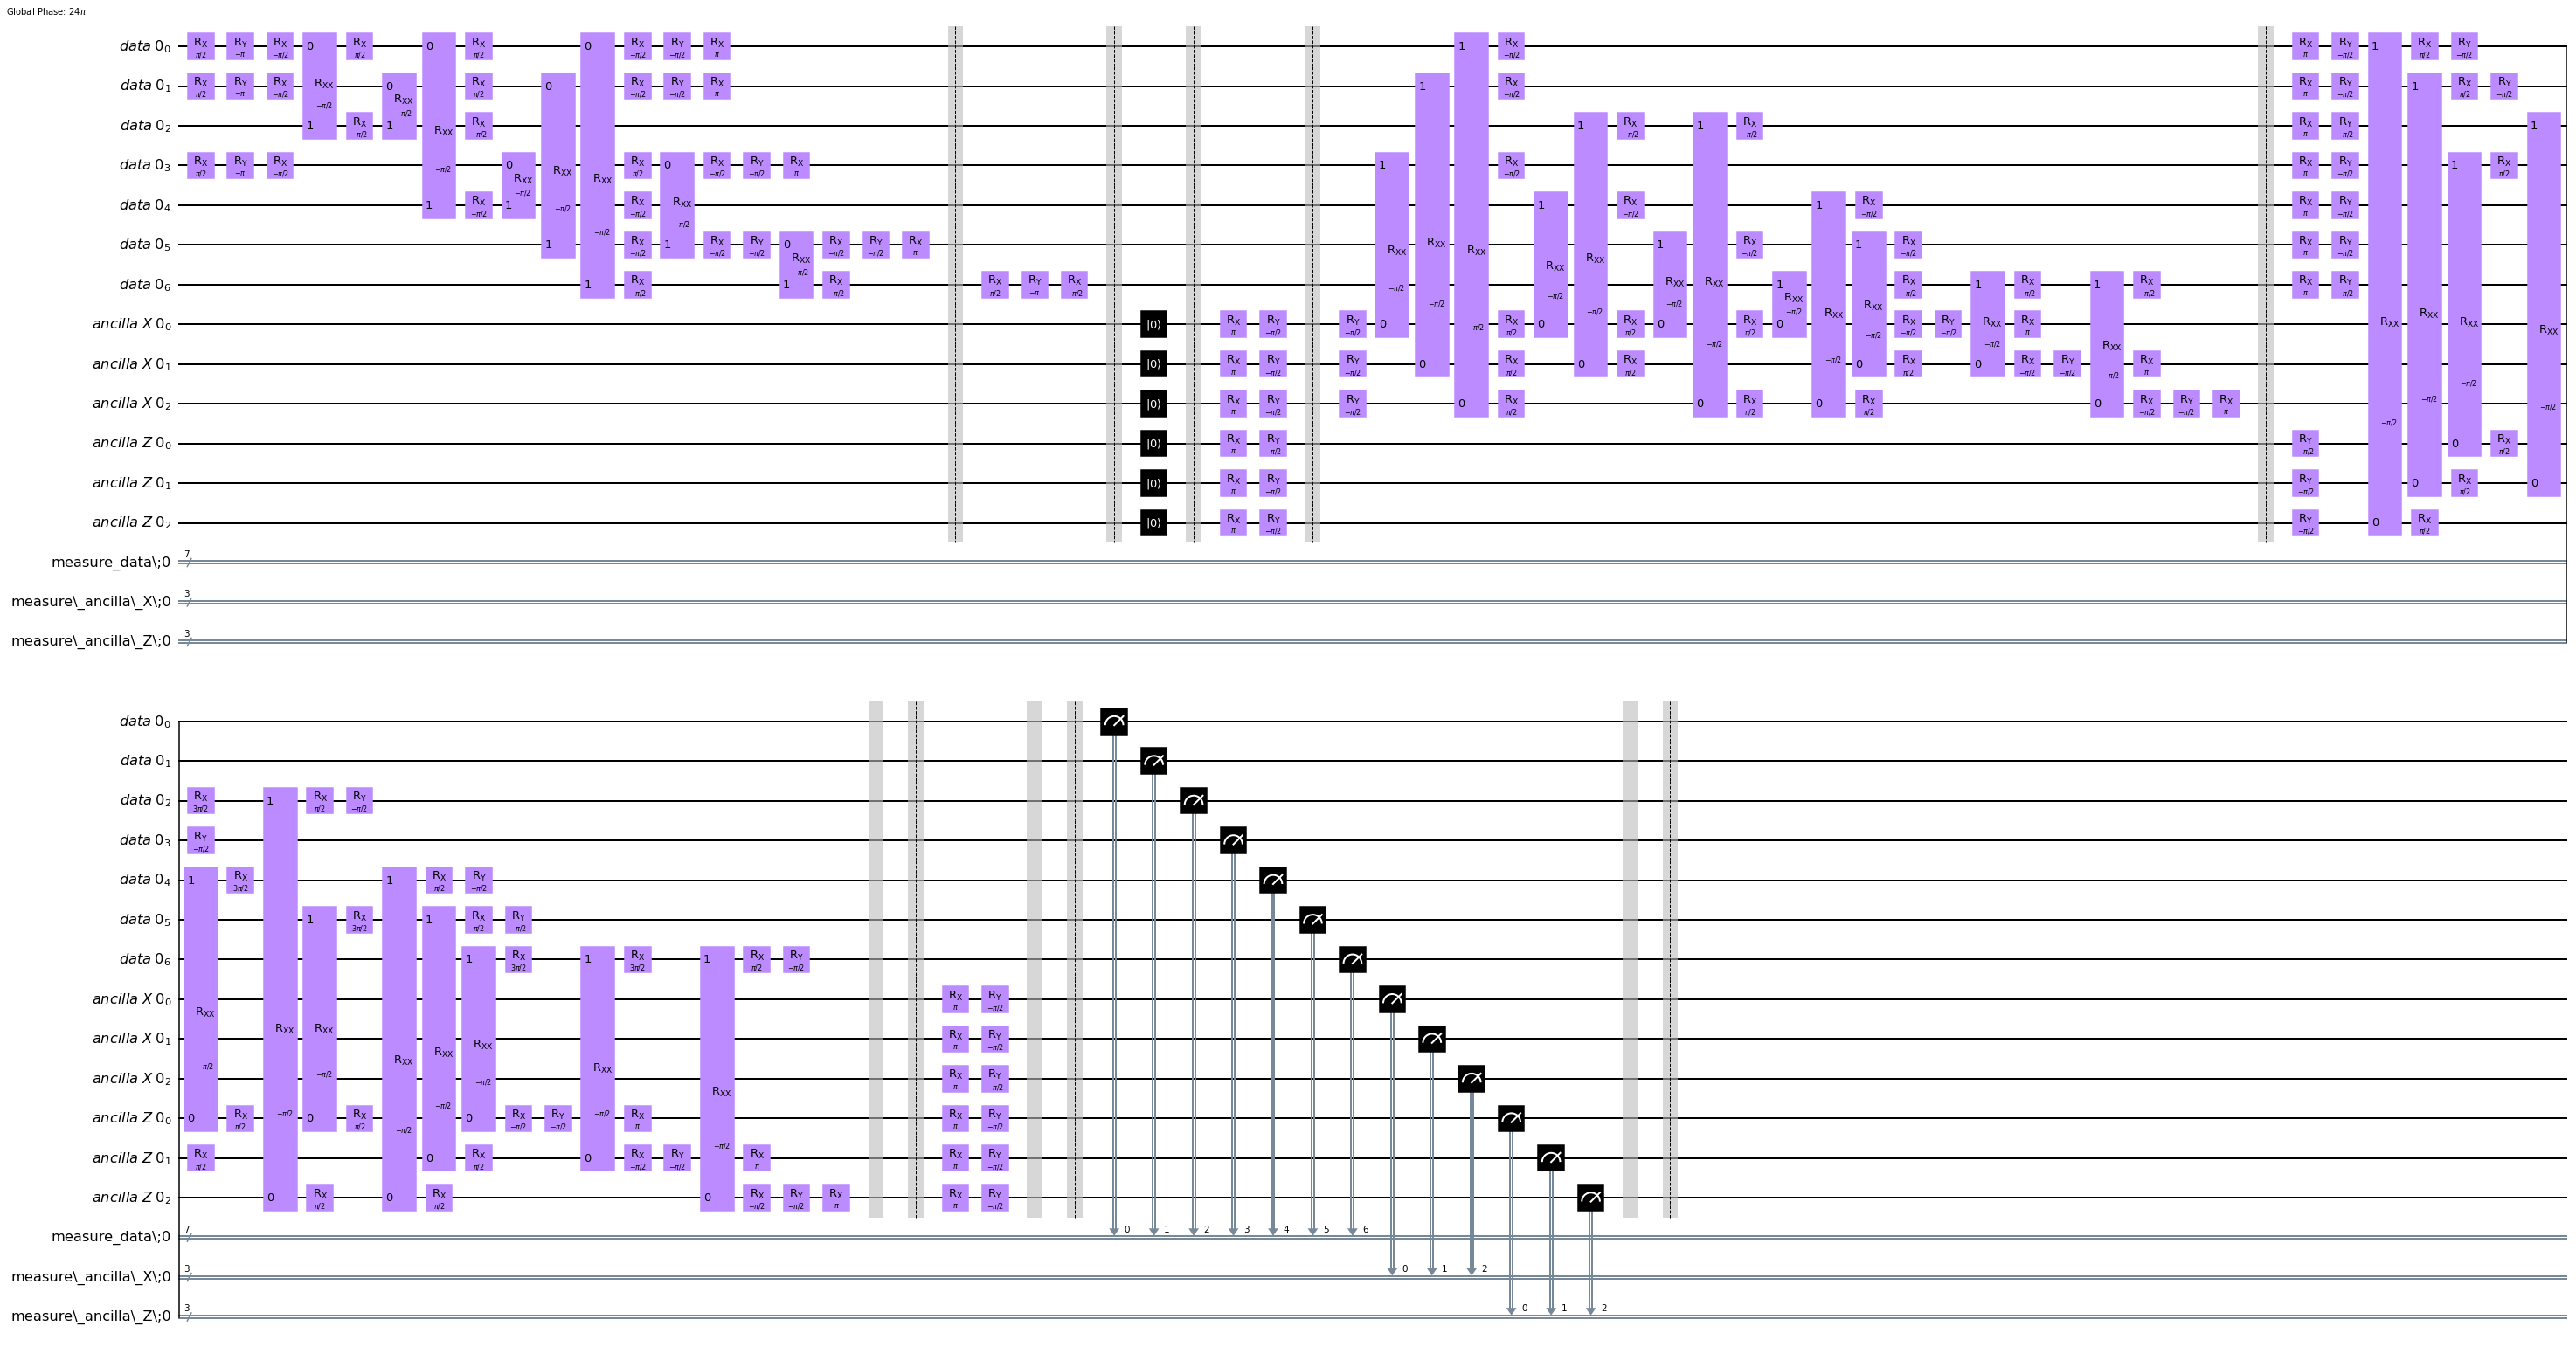

In [9]:
qt.draw(output = 'mpl', filename = 'Steane_code_error_detection_circuit_transpiled.jpg', fold = 60)